In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import time

In [2]:
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Singlelayer_NN_Model


In [3]:
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [4]:
#Function that plots 1 or 2 simulated spectra on top of each other (for comparison)
def plotter(dens, temp, flor, err,dx=0.5e-4, dens2=3, temp2=3, flor2=0.003, err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    dens2 = [dens2]
    temp2 = [temp2]

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM

    target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    target2 = SCRAMTarget(dens2,temp2,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx2)
    #generating test spectra with noise
    test_VH, test_HR = target1.model(dens,temp,flor,100)
    test_VH2, test_HR2 = target2.model(dens2,temp2,flor2,100)    
    error = err #controls how noisy the spectra are
    error2 = err2
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)   
    noise_VH2 = np.random.normal(0,error2*np.std(test_VH2),en_VH.shape)
    noise_HR2 = np.random.normal(0,error2*np.std(test_HR2),en_HR.shape)
    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')
        axs[0].plot(en_VH,test_VH+noise_VH, label = 'Simulated')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        
        axs[1].plot(en_HR,test_HR+noise_HR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        
        if compare == True:
            axs[0].plot(en_VH,test_VH2+noise_VH2, label = 'Predicted', linestyle = '--')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()

            axs[1].plot(en_HR,test_HR2+noise_HR2, linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
            axs[1].legend()
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    intensity = []
    intensity.append(test_VH+noise_VH)

    energy_intensity_df = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensity)])
    return energy_intensity_df

In [6]:
#Plotter2 plots one spectra from an array of points, and simulates one using SCRAM
def plotter2(dens, temp, flor, err,dx=0.5e-4, exp_specVH = [],exp_specHR=[],  err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM


    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,exp_specVH, label = 'Experimental')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        

        axs[1].plot(en_HR,exp_specHR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        axs[1].legend()
        
        if compare == True:
            target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx)
    
            #generating test spectra with noise
            #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
            test_VH, test_HR = target1.model(dens,temp,flor,100)

            error = err #controls how noisy the spectra are
            error2 = err2
            noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
            
            
            
            axs[0].plot(en_VH,test_VH+noise_VH, linestyle = '--',label = 'Predicted')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()
        
            axs[1].plot(en_HR,test_HR+noise_VH,  linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    
    
    return noise_VH

In [15]:

# Constants
num_files = 65
num_trials = 1000
dx = 0.5e-4  # Single layer of thickness 500 nm

# Initialize SCRAM and get interpolators
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
en_VH = np.linspace(8, 9.97, 2995)
en_HR = np.linspace(8, 9.97, 2995)  # Spectral range of front side von Hamos spectrometer
j, k, j_f, k_f, fh, fj = scram.get_scram_intrp(dx)

# Pre-generate random values for density, temperature, and fluorescence

# Prepare arrays to store results



# Loop through each trial
for n in range(num_files):
    intensities = []
    variables = []
    for i in range(num_trials):
        dens = np.random.uniform(2.23,10.764)
        temp = np.random.uniform(1,6.4)
        flor = 1e-3
        error = np.random.uniform(0,0.3)
        target = SCRAMTarget([dens], [temp], j, k, j_f, k_f, fh, fj, en_VH, en_HR, dx)
        # Create SCRAM target
        # Generate test spectra
        test_VH, _ = target.model([dens], [temp], flor, 100)
        # Add noise to the spectra
        noise_VH = np.random.normal(0, error * np.std(test_VH), en_VH.shape)
        # Combine the spectra and store in arrays
        intensities.append(test_VH + noise_VH)
        variables.append([dens, temp])
        

    # Convert to DataFrame
    energy_intensity_df = pd.DataFrame(intensities)
    dens_temp_noise_df = pd.DataFrame(variables)

    # Save DataFrames
    joblib.dump(energy_intensity_df, f'{base_path}\\rawhigh\\EID_{n}.pkl')
    joblib.dump(dens_temp_noise_df, f'{base_path}\\rawhigh\\DTF_{n}.pkl')
    print(n)


5e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [13]:
energy_intensity_df.iloc[999,:]

0       0.974759
1       0.507923
2       0.456544
3       0.317656
4       0.118117
          ...   
2990    0.274903
2991    0.100619
2992   -0.120369
2993   -0.119081
2994   -0.015424
Name: 999, Length: 2995, dtype: float64

5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


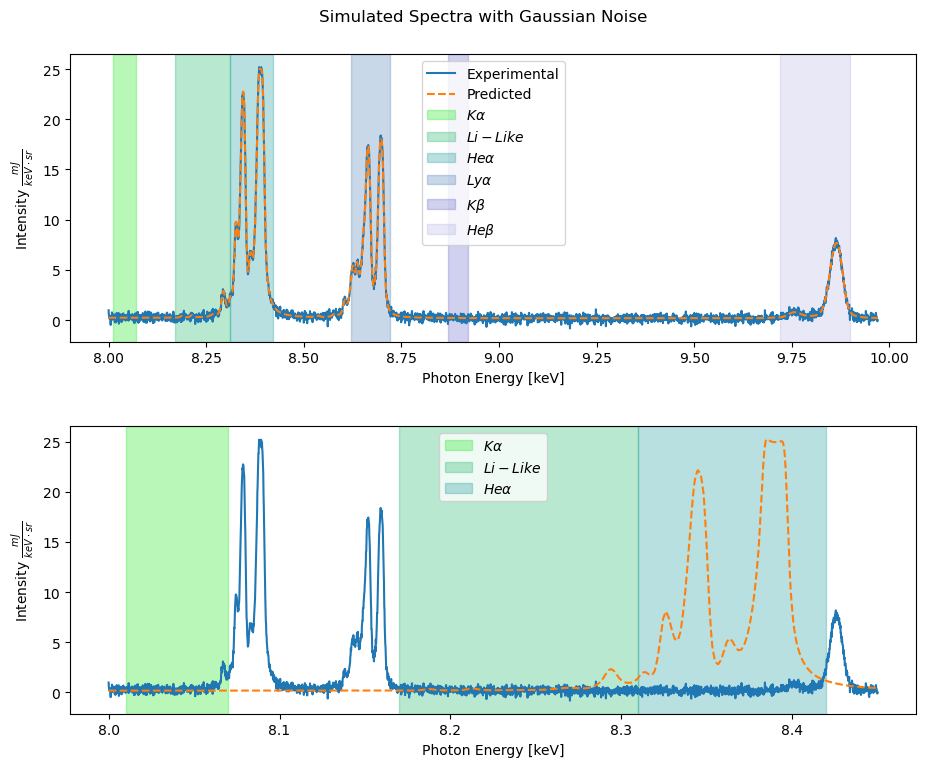

In [14]:
x = plotter2(dens,temp,1e-3,0, exp_specVH = energy_intensity_df.iloc[-1,:], exp_specHR=energy_intensity_df.iloc[-1,:],ploton=True,compare=True )